<a href="https://colab.research.google.com/github/saktiworkstation/GNNs-LLMs-Research/blob/main/GNN_DOVE_simplification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F

In [6]:
df = pd.read_csv('/content/all-pairwise-interactions.csv')

In [7]:
print("Data Overview:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nDescriptive Stats:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Data Overview:
  PDB Code                                              Title Complex Type  \
0     10gs  'HUMAN GLUTATHIONE S-TRANSFERASE P1-1, COMPLEX...         HOMO   
1     121p  'STRUKTUR UND GUANOSINTRIPHOSPHAT-HYDROLYSEMEC...         HOMO   
2     13gs  'GLUTATHIONE S-TRANSFERASE COMPLEXED WITH SULF...         HOMO   
3     15c8                 'CATALYTIC ANTIBODY 5C8, FREE FAB'       HETERO   
4     17gs                   'GLUTATHIONE S-TRANSFERASE P1-1'         HOMO   

  Biounit chain name (1)  Model number (1) Chain Content (1)  \
0                      A                 1          PeptideL   
1                      A                 1          PeptideL   
2                      A                 1          PeptideL   
3                      H                 1          PeptideL   
4                      A                 1          PeptideL   

  Biounit chain name (2)  Model number (2) Chain Content (2)  \
0                      B                 1          PeptideL   
1  

**Preprocessing**

In [13]:
# Handle categorical data
le = LabelEncoder()
df['Complex Type'] = le.fit_transform(df['Complex Type'])

# Convert date to datetime and extract year
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Release Year'] = df['Release Date'].dt.year.fillna(0).astype(int)

# Select features and target
features = ['Complex Type', 'Model number (1)', 'Model number (2)', 'Release Year']
target = 'Mean area buried by each chain'

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(df[features])
y = df[target].values

**Data Visualization**

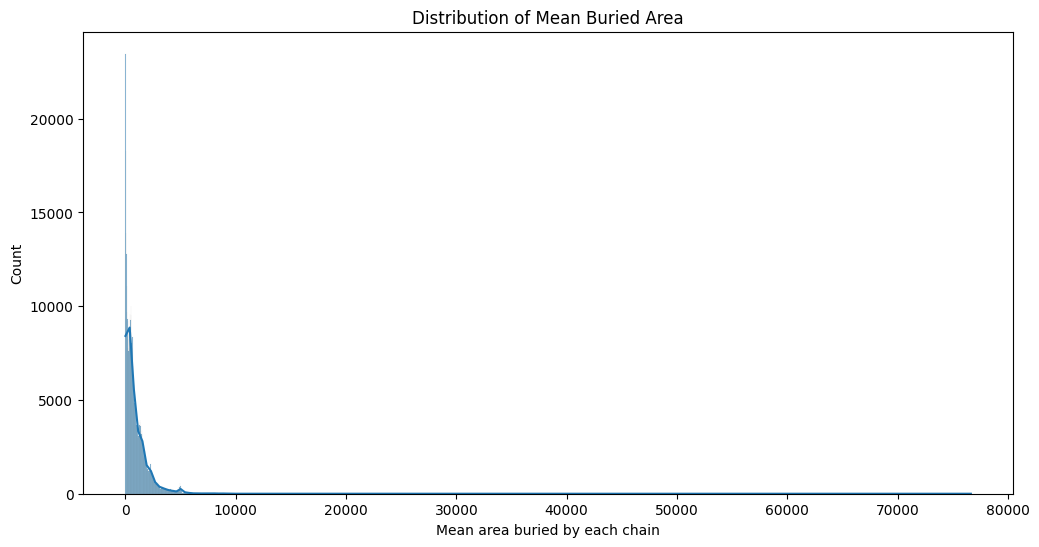

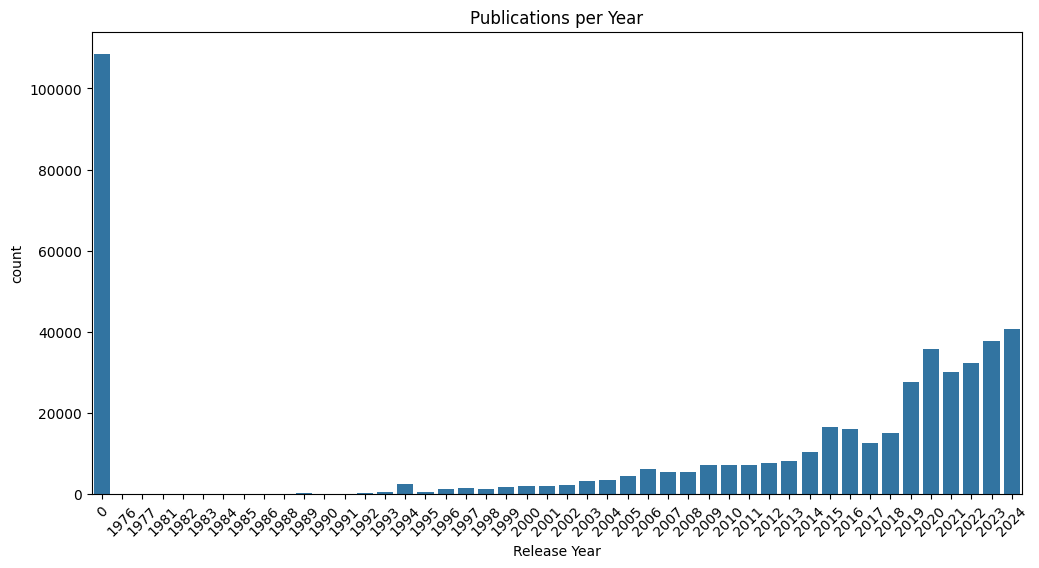

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Mean area buried by each chain'], kde=True)
plt.title('Distribution of Mean Buried Area')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='Release Year', data=df)
plt.title('Publications per Year')
plt.xticks(rotation=45)
plt.show()

**Prepare Graph Data**

In [ ]:
# Create edge indices (example: connect nodes with similar release years)
edge_list = []
for i in range(len(df)):
    for j in range(len(df)):
        if abs(df['Release Year'][i] - df['Release Year'][j]) < 2:
            edge_list.append([i, j])

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# Create PyG Data object
data = Data(
    x=torch.tensor(X, dtype=torch.float),
    edge_index=edge_index,
    y=torch.tensor(y, dtype=torch.float)
)

train_mask, test_mask = train_test_split(
    range(len(df)),
    test_size=0.2,
    random_state=42
)

data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
data.test_mask = torch.tensor(test_mask, dtype=torch.bool)

**Setup model**

In [11]:
class DOVE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DOVE, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return x

model = DOVE(input_dim=len(features), hidden_dim=32, output_dim=1)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out[mask]
        true = data.y[mask]
        rmse = torch.sqrt(criterion(pred, true))
    return rmse.item()

In [ ]:
best_rmse = float('inf')
for epoch in range(1, 201):
    loss = train()
    train_rmse = test(data.train_mask)
    test_rmse = test(data.test_mask)

    if test_rmse < best_rmse:
        best_rmse = test_rmse
        torch.save(model.state_dict(), 'best_model.pth')

    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}')

In [ ]:
hidden_dims = [16, 32, 64]
learning_rates = [0.001, 0.0005]

results = {}
for dim in hidden_dims:
    for lr in learning_rates:
        model = DOVE(len(features), dim, 1)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train briefly for demonstration
        for epoch in range(50):
            train()

        test_rmse = test(data.test_mask)
        results[f'dim_{dim}_lr_{lr}'] = test_rmse
        print(f'Config: dim={dim}, lr={lr} - RMSE: {test_rmse:.2f}')

In [ ]:
best_config = min(results, key=results.get)
print(f'Best configuration: {best_config} with RMSE: {results[best_config]:.2f}')